In [1]:
import glob
import numpy as np

In [2]:
frds = glob.glob('output/ccx/*/*.frd')
dats = glob.glob('output/ccx/*/*.dat')

In [3]:
# dats = dats[1:]
# frds = frds[1:]

In [4]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [5]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [6]:
from FEM_traccion.CreateLines.CreateLines import CreateLines

lines = CreateLines({
        "r": 2.5,
        "Nx_sq": 1,
        "Ny_sq": 1,
        "type":  'sin' # 'circle' or 'sin'
    })

In [7]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [8]:
design = [ lines["designs"][idesign]["ly_0"]
         for idesign in ["SX","SY","X","Y"] ]

In [9]:
from gmshtools.grid_section import grid_section
from matplotlib import pyplot as plt

In [10]:
%matplotlib ipympl

In [11]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [12]:
ifrd = readfrd(frds[0])
idesign = design[0]


In [13]:
data = ifrd["data"]

In [14]:
ymin = 0.5 
ymax = 9.5
xmin = 0.5
xmax = 9.5

data = data[data["x"] > xmin]
data = data[data["x"] < xmax]
data = data[data["y"] > ymin]
data = data[data["y"] < ymax]


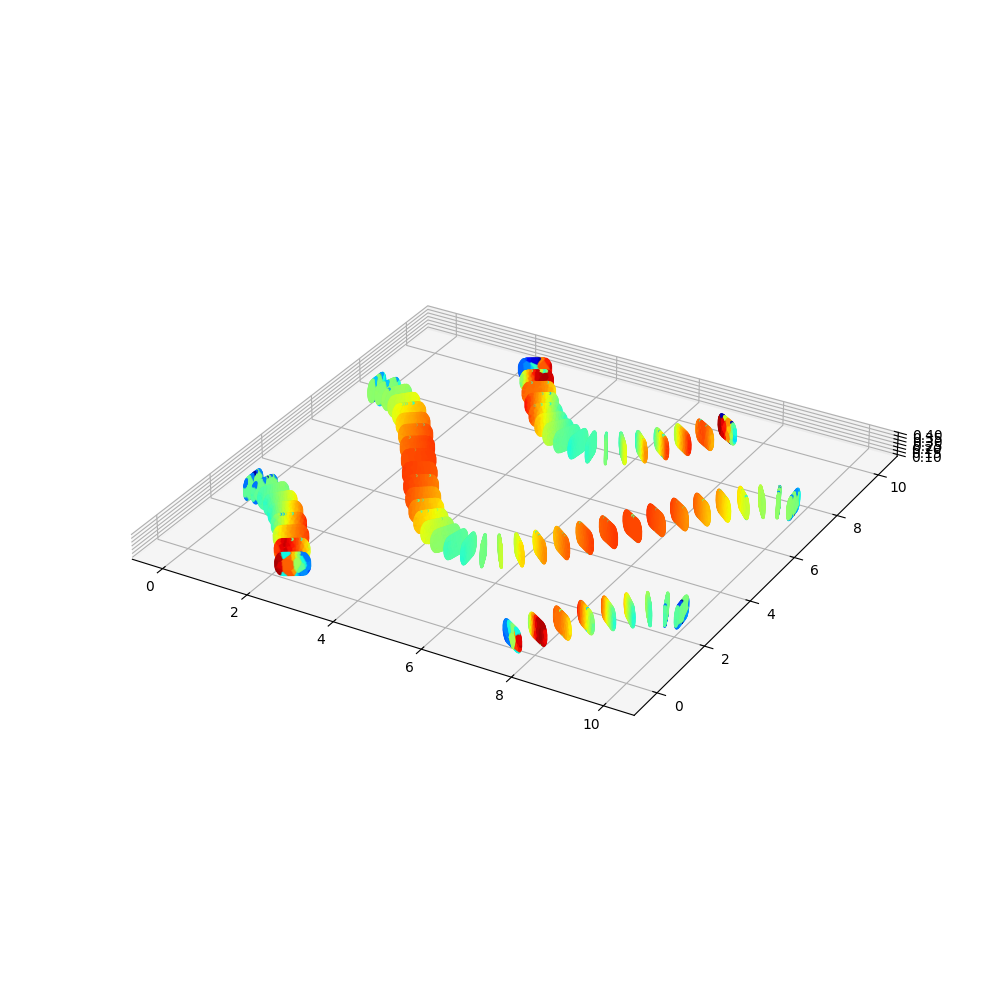

In [15]:
# neartest neighbor interpolation
from scipy.interpolate import NearestNDInterpolator


x = data["x"]
y = data["y"]
z = data["z"]
P1 = data["P1"]

fcn = NearestNDInterpolator((x,y,z),P1)

d = params_composite["d"]
r = params_composite["r"]

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')


colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']

P1_mean_trajs = []
for jj,jtrajs in enumerate(idesign):

    jtraj_diff = np.diff(jtrajs,axis=0)

    P1_mean = []
    for j in range(0,len(jtraj_diff),600):

        vec_z =  jtraj_diff[j]
        vec_z = vec_z/np.linalg.norm(vec_z)
        vec_x = np.cross(vec_z, [0,0,1])
        vec_x = vec_x/np.linalg.norm(vec_x)

        X,Y,Z = grid_section(jtrajs[j][0],
                            jtrajs[j][1],
                            jtrajs[j][2],
                            vec_z,
                            vec_x,
                            0.8*d,
                            0.8*r,
                            rho=150)
        Z = Z + params_composite["h"]/2
        P1 = fcn(X,Y,Z)
        P1
        # ax.plot(X,Y,Z, alpha=0.5, color=colors[jj])
        ax.scatter(X,Y,Z, c=P1, alpha=0.5, marker='o', s=1, cmap='jet',vmin=0, vmax=500)
        P1_mean.append({
            "x": np.mean(X),
            "y": np.mean(Y),
            "z": np.mean(Z),
            "P1": np.mean(P1),
        })
    P1_mean_trajs.append(P1_mean)
# aspect ratio 
plt.gca().set_box_aspect([1,1,0.05])  # aspect ratio is 1:1:1
# # off ticks 
# plt.xticks([])
# plt.yticks([])


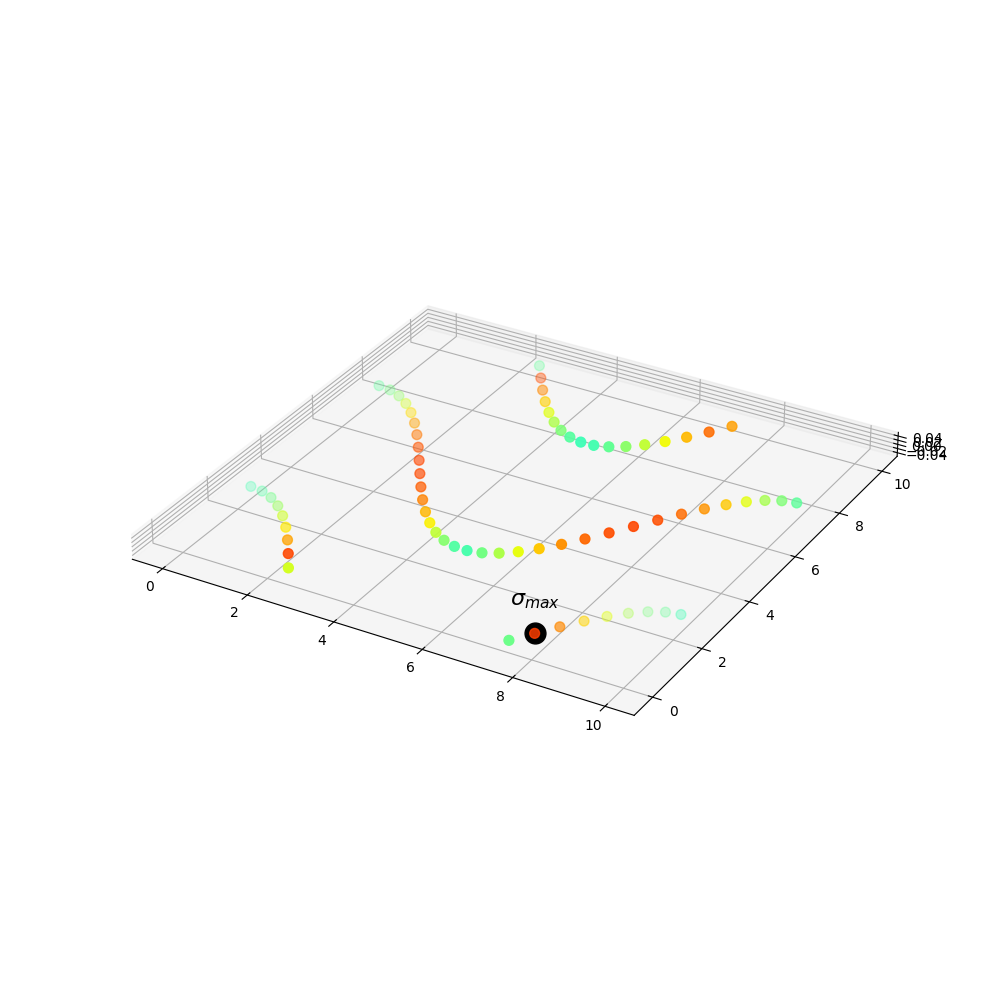

In [16]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')

maximuns = []
for iP1_traj in P1_mean_trajs:
    x = [ii["x"] for ii in iP1_traj]
    y = [ii["y"] for ii in iP1_traj]
    z = [ii["z"] for ii in iP1_traj]
    P1 = [ii["P1"] for ii in iP1_traj]

    idx_P1_max_line = np.argmax(P1)
    xmax_line = x[idx_P1_max_line]
    ymax_line = y[idx_P1_max_line]
    zmax_line = z[idx_P1_max_line]
    P1max_line = P1[idx_P1_max_line]

    maximuns.append({
        "x": xmax_line,
        "y": ymax_line,
        "z": zmax_line,
        "P1": P1max_line,
    })

    plt.scatter(x,y,200, c=P1, marker='.',cmap='jet',vmin=0, vmax=500)

id_P1_max = np.argmax([ii["P1"] for ii in maximuns])
xmax = maximuns[id_P1_max]["x"]
ymax = maximuns[id_P1_max]["y"]
zmax = maximuns[id_P1_max]["z"]
P1max = maximuns[id_P1_max]["P1"]

plt.plot(xmax,ymax,0, marker='o', color='black', markersize=15, label="P1 max")
# text box with arrow and border line
ax.text(xmax, ymax, 0.1, r'$\sigma_{max}$', fontsize=16, color='black', ha='center', va='bottom')
plt.gca().set_box_aspect([1,1,0.05])  # aspect ratio is 1:1:1
